# Assignment 2
## Web Scraping and using Classifiers

### Conor Kneafsey
### 16405754

In [1]:
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

## Task 1 - Data Collection
Our first step was to collect the relevant details of the articles containing the 3 chosen categories. For our categories we chose to take articles relating to Politics, Sport and US-News. It would be interesting to see how the classifier would perform with categories that wouldn't be related like Politics and Sport compared to categories that might have more in common with each other like Politics and US-News. 

To find the link for each month, we have to parse the html and search for the given tag. We then iterated through the total pages for that month and every article within that month. The category for each article was assessed and it was only added if it matched one of the chosen categories. 

A JSON format was chosen as its hierarchical structure suited the type of information we had while being easy to work with

In [2]:
# Using the link passed as an argument, try obtain a response and parse the html
def htmlParser(link):
    try: # try obtain response from link
        response = urllib.request.urlopen(link)
        html = response.read().decode() # decode the html
        parser = BeautifulSoup(html,"html.parser") # parse the html
    except: # if exception occurs, print message
        print('No response from: ', link)
    
    return parser

# Process the parsed info given the chosen categories and return only articles relating to those
def processInfo(parser, chosenCat):
    flag = 0
    i = 0
    for match in parser.find_all(["h5", "p"]):
        if i == 1: # only find the titles
            lastTitle = match.get_text().lstrip('0123456789.- ') # remove the number before the title

        elif i == 3: # only include the categories
            if match.get_text().split()[1] in chosenCat: # check if category matches
                title.append(lastTitle)
                category.append(match.get_text().split()[1]) # remove the "Category: " part of the line
                flag = 1 # set flag to indicate this article should be saved

        elif i == 4: # only include the article text
            if flag: 
                article.append(match.get_text())
                flag = 0
            i = 0
        i += 1
    return title, category, article
    
title = []
category = []
article = []
chosenCat = ["Politics", "Sport", "US-News"] # these are the categories we shall scrape
base = "http://mlg.ucd.ie/modules/COMP41680/assignment2/month-"
month = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
end = "-001.html"
for m in month:
    link = base + m + end
    parser = htmlParser(link) # parse the html from the link

    for match in parser.find_all("h4"): # find the amount of pages
        pgNum = match.get_text().split() # split the string in order to find the amount of pages

#     create a link for every page, then parse the html and process the articles
    for i in range(1, int(pgNum[-1])+1):
        num = '-' + "%03d" % i # convert i to string with 3 digits
        link = base + m + num + ".html"
        parser = htmlParser(link) # parse the html from the link
        title, category, article = processInfo(parser, chosenCat) # process the parsed html
df = pd.DataFrame({'Title':title, 'Category':category, 'Article text':article}) # create a dataframe with the given headers
df.to_json(r'Articles.json') # output the dataframe to a .json file

## Task 2 - Binary Text Classification
Our first step is to load in the data from the previously saved JSON file and create a set of documents that would combine the articles title and text. In order to achieve this second step, we created a new column in the dataframe which combined the article title and text

In [3]:
df = pd.read_json("Articles.json") # read in the info from the .json file into a dataframe
df["Doc"] = df["Title"] + " " + df["Article text"] # add another column combining the title and article text

### TFIDF Vectorizer
In order to use the data in a classifier, we need to do some preprocessing steps first. We chose to use a TF-IDF Vectorizer to help preprocess the data. This is because it can help weigh the importance of some terms while excluding common words that are used that may have no influence of the category of the article. It uses Term Frequency (TF) which is the amount a term appears in a document. The IDF part of the name comes from Inverse Document Frequency which means if  a term appears in lots of documents then it is given a lesser weight as it is not that useful in determining the category

### K Nearest Neighbor Classifier
The binary classifier we chose to use was the K-nearest neighbor classifier. This was chosen as it is good at categorising text and therefore we can determine the category of that article. It gave us good results and after some trial and error, it was found that 100 nearest neighbours gave us a high accuracy score

Accuracy for Politics and Sport = 97.38%


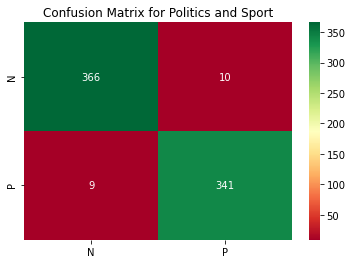

In [4]:
# function to take in a dataframe and carry out the necessary preprocessing steps before classification
def preProcessing(df_pre):
    # split the data into training and target documents
    pre_train_docs, pre_test_docs, pre_train_target, pre_test_target = train_test_split(df_pre["Doc"], df_pre["Category"], test_size=0.2)
    vectorizer = TfidfVectorizer(stop_words="english", min_df = 5) # use a TFIDF vectorizer
    pre_train_X = vectorizer.fit_transform(pre_train_docs) # fit and transform the training documents using our vectorizer
    pre_test_X = vectorizer.transform(pre_test_docs) #transform our test documents using our vectorizer
    return pre_train_X, pre_test_X, pre_train_target, pre_test_target

# function to display the accuracy of our model using an accuracy score and confusion matrices
def accuracy(test_target, predicted, cat1, cat2):
    acc = round(accuracy_score(test_target, predicted)*100, 2) # calculate the accuracy and convert to a percentage
    print("Accuracy for "+cat1+" and "+cat2+" = "+str(acc)+"%")
    
    confuse = confusion_matrix(test_target, predicted) # make a confusion matrix for the model
    plt.figure()
    sb.heatmap(confuse, cmap="RdYlGn", xticklabels=["N","P"], yticklabels=["N","P"], annot=True, fmt=".0f")
    plt.title("Confusion Matrix for "+cat1+" and "+cat2)
    
# function to use the classifier on the train and test documents
def classifier_model(df_class):
    train_X, test_X, train_target, test_target = preProcessing(df_class)
    model = KNeighborsClassifier(n_neighbors=100)
    model.fit(train_X, train_target)
    predicted = model.predict(test_X)
    return test_target, predicted

df_class = df.loc[df["Category"] != "US-News"] # dataframe that excludes any rows that are categorised as US-News

test_target, predicted = classifier_model(df_class) # use the classifier on the new dataframe
accuracy(test_target, predicted, chosenCat[0], chosenCat[1]) # display the results of the classifier

As we can see, this classifier did very well when deciding whether an article was in the Politics or Sport category. It has an accuracy score of 97.38% which is very high. We can also see from the confusion matrix that it has classified them very well with very few false positives or false negatives. Overall, the choice of a k-nearest neighbour classifier has worked well

Accuracy for Politics and US-News = 96.69%


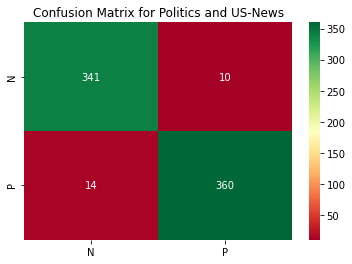

In [5]:
df_class = df.loc[df["Category"] != "Sport"] # dataframe that excludes any rows that are categorised as Sport

test_target, predicted = classifier_model(df_class) # use the classifier on the new dataframe
accuracy(test_target, predicted, chosenCat[0], chosenCat[2]) # display the results of the classifier

Once again, the classifier has worked well on 2 categories that could  have many similarities between them. We can see the score is 96.69% which is very high and the confusion matrix shows us the false positive and negative rate which is low

Accuracy for Sport and US-News = 96.01%


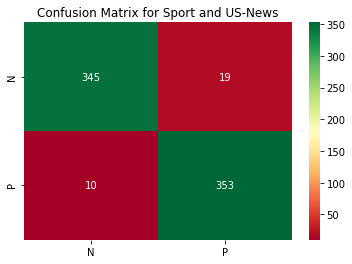

In [6]:
df_class = df.loc[df["Category"] != "Politics"] # dataframe that excludes any rows that are categorised as Politics

test_target, predicted = classifier_model(df_class) # use the classifier on the new dataframe
accuracy(test_target, predicted, chosenCat[1], chosenCat[2]) # display the results of the classifier

We can conclude that the k nearest neighbour classifer with 100 neighbours worked extremely well at defining the categories of the articels with all 3 pairs having an accuracy above 96% and their confusion matrices having a low amount of false negatives and positives

## Task 3 - Multi-Class Text Classification
This task was similar to our last one but instead of using a binary classifier, we had to use a multi-class classifier to work on all 3 categories at once. We chose to use the same preprocessing steps as before as their relevance still applied. We also chose to use the K nearest neighbour classifier as it can also work for multi-class classification and it meant we could re-use the same code we had previously written. The performance was still very high so the k nearest neighbour was a good choice for multi class classification

We did have to update our accuracy function as it would not work for a multi-class classification. We still used the accuracy_score function to display how well the classifier performed. We adjusted the confusion matrix so it displayed a 3x3 matrix instead showing how each category was predicted compared to their actual category

Accuracy of the multi-class classifer = 94.86%


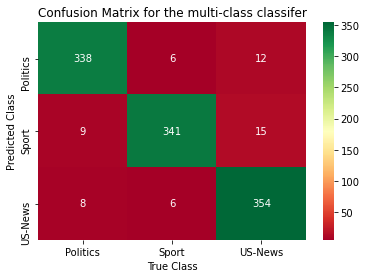

In [7]:
# Function to display accuracy of multi-class classifier
def acc_multi_class(test_target, predicted):
    acc = round(accuracy_score(test_target, predicted)*100, 2) # round accuracy and display as percentage
    print("Accuracy of the multi-class classifer = "+str(acc)+"%")
    
    confuse = confusion_matrix(test_target, predicted) # make a confusion matrix for the mulit-class classifier
    plt.figure()
    sb.heatmap(confuse, cmap="RdYlGn", annot=True, fmt=".0f", xticklabels=chosenCat, yticklabels=chosenCat)
    plt.title("Confusion Matrix for the multi-class classifer")
    plt.xlabel("True Class")
    plt.ylabel("Predicted Class")

test_target, predicted = classifier_model(df) # use the classifier on the complete dataframe containing all categories
acc_multi_class(test_target, predicted) # display the accuracy of the classifier

We can see that the k nearest neighbour classifier still performed very well at this task. However, we do note that it is lower at 94.86% than when it was used as a binary classifier. This is to be expected as there are more categories so it is more likey something could be classsified wrong. However, when viewing the confusion matrix, we can see that there are still very few wrongly classified articles, particularly when looking at the Sport category.

Overall the k nearest neighbour has performed very well in conjuction with the TFI-DF vectorizer for both binary and multi-class classification. We can see how useful they are in text classification tasks after this assignment using them on data obtained from web scraped articles.